# Neural Style

The principe is simple: we define two distances, one for the content ($D_C$) and one for the style ($D_S$). $D_C$ measues how different is the content between two images, while $D_S$ measures how different is the style between two images. Then, we take a third image, the input, (e.g. a with noise), and we transform it in order to both minimize its content-distance with the content-image and its style-distance with the style-image.


Well, going further requires some mathematics. Let $C_{nn}$ be a pre-trained deep convolutional neural network and $X$ be any image. $C_{nn}(X)$ is the network fed by $X$ (containing feature maps at all layers). Let $F_{XL} \in C_{nn}(X)$ be the feature maps at depth layer $L$, all vectorized and concatenated in one single vector. We simply define the content of $X$ at layer $L$ by $F_{XL}$. Then, if $Y$ is another image of same the size than $X$, we define the distance of content at layer $L$ as follow:

$$D_C^L(X,Y) = \|F_{XL} - F_{YL}\|^2 = \sum_i (F_{XL}(i) - F_{YL}(i))^2$$

Where $F_{XL}(i)$ is the $i^{th}$ element of $F_{XL}$. The style is a bit less trivial to define. Let $F_{XL}^k$ with $k \leq K$ be the vectorized $k^{th}$ of the $K$ feature maps at layer $L$. The style $G_{XL}$ of $X$ at layer $L$ is defined by the Gram produce of all vectorized feature maps $F_{XL}^k$ with $k \leq K$. In other words, $G_{XL}$ is a $K$x$K$ matrix and the element $G_{XL}(k,l)$ at the $k^{th}$ line and $l^{th}$ column of $G_{XL}$ is the vectorial produce between  $F_{XL}^k$ and $F_{XL}^l$:

$$G_{XL}(k,l) = \langle F_{XL}^k, F_{XL}^l\rangle = \sum_i F_{XL}^k(i) . F_{XL}^l(i)$$

Where $F_{XL}^k(i)$ is the $i^{th}$ element of $F_{XL}^k$. We can see $G_{XL}(k,l)$ as a measure of the correlation between feature maps $k$ and $l$. In that way, $G_{XL}$ represents the correlation matrix of feature maps of $X$ at layer $L$. Note that the size of $G_{XL}$ only depends on the number of feature maps, not on the size of $X$. Then, if $Y$ is another image *of any size*, we define the distance of style at layer $L$ as follow:

$$D_S^L(X,Y) = \|G_{XL} - G_{YL}\|^2 = \sum_{k,l} (F_{XL}(k,l) - F_{YL}(k,l))^2$$

In order to minimize in one shot $D_C(X,C)$ between a variable image $X$ and target content-image $C$ and $D_S(X,S)$ between $X$ and target style-image $S$, both computed at several layers , we compute and sum the gradients (derivative with respect to $X$) of each distance at each wanted layer:

$$\nabla_{\textit{total}}(X,S,C) = \sum_{L_C} w_{CL_C}.\nabla_{\textit{content}}^{L_C}(X,C) + \sum_{L_S} w_{SL_S}.\nabla_{\textit{style}}^{L_S}(X,S)$$

Where $L_C$ and $L_S$ are respectivement the wanted layers (arbitrary stated) of content and style and $w_{CL_C}$ and $w_{SL_S}$ the weights (arbitrary stated) associated with the style or the content at each wanted layer. Then, we run a gradient descent over $X$:

$$X \leftarrow X - \alpha \nabla_{\textit{total}}(X,S,C)$$

Ok. That's enough with maths. If you want to go deeper (how to compute the gradients) **we encourage you to read the original paper** by Leon A. Gatys and AL, where everything is much better and much clearer explained. For our implementation in PyTorch, we already have everything we need: indeed, with PyTorch, all the gradients are automatically and dynamically computed for you (while you use functions from the library). This is why the implementation of this algorithm becomes very confortable with PyTorch. 

In [3]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import PIL                      #New datatype
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

In [4]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

print dtype

<type 'torch.FloatTensor'>


In [5]:
imsize = 200  # desired size of the output image(if content and style image are of different in size then can be resize easily)
#Preprocessing Step
loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image    make shape of (200,200)
    transforms.ToTensor()])  # transform it into a torch tensor

preprocess = loader

#preprocesssor
def image_loader(image_name):             #load the image and do further oprtn
    image = Image.open(image_name)
    image = Variable(preprocess(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)             #unsqueeze for batch 
    return image


style = image_loader("/home/chintan/Class_Code/Class19(Deep Dream)/Prisma Resources/filter.jpg").type(dtype)
print style.shape
content = image_loader("/home/chintan/Class_Code/Class19(Deep Dream)/Prisma Resources/images/Lock (42).jpg").type(dtype)

print content.shape

/usr/local/lib/python2.7/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


torch.Size([1, 3, 200, 355])
torch.Size([1, 3, 200, 355])


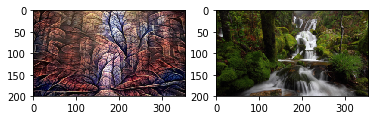

In [6]:
#Deprocess step
unloader = transforms.ToPILImage()  # reconvert into PIL image


def imshow(tensor):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, 355)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)


fig = plt.figure(0)

plt.subplot(221)
imshow(style.data)
plt.subplot(222)
imshow(content.data)

### Content loss

The content loss is a function that takes as input the feature maps $F_{XL}$ at a layer $L$ in a network fed by $X$ and return the weigthed content distance $w_{CL}.D_C^L(X,C)$ between this image and the content image. Hence, the weight $w_{CL}$ and the target content $F_{CL}$ are parameters of the function. We implement this function as a torch module with a constructor that takes these parameters as input. The distance $\|F_{XL} - F_{YL}\|^2$ is the Mean Square Error between the two sets of feature maps, that can be computed using a criterion `nn.MSELoss` stated as a third parameter.

We will add our content losses at each desired layer as additive modules of the neural network. That way, each time we will feed the network with an input image $X$, all the content losses will be computed at the desired layers and, thanks to autograd, all the gradients will be computed. For that, we just need to make the `forward` method of our module returning the input: the module becomes a ''transparent layer'' of the neural network. The computed loss is saved as a parameter of the module.

Finally, we define a fake `backward` method, that just call the backward method of `nn.MSELoss` in order to reconstruct the gradient. This method returns the computed loss: this will be usefull when running the gradien descent in order to display the evolution of style and content losses.

In [7]:
#detach functionis basically detach the tree whose gradients now doesnot compute 
#We donot require the gradient here for content and style image so we datch th target from tree in content and style both


#We are going to find the content loss that is simply taking the difference of feature vectors by taking mean square loss
#And fr style loss we just make a gram matrix then take difference of both of them to get style loss

class ContentLoss(nn.Module):
    def __init__(self, target, weight):     #input image, content image and weight here it is alpha
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight #backprop vala tree hai is tree ko detach krdo iske gradient compute no meaning  
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()  #Taking means square loss 

    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight, self.target)  #self.criterian is basically meansquareloss in self.target is already multiplied with weight means alpha
        self.output = input
        return self.output

    def backward(self, retain_variables=True):    #Is case me buffer khali nhi krana and we want to run backward passs run multiple times that why we are going to true
        self.loss.backward(retain_graph=retain_variables)
        return self.loss
    
    
    #What we are going to do we are stack all the three images,now batchsize=3 images are content,style and output image we need the output image should exactly be the same as of content and the maximum probability of style should exists on the image

**Important detail**: this module, although it is named `ContentLoss`, is not a true PyTorch Loss function. If you want to define your content loss as a PyTorch Loss, you have to create a PyTorch autograd Function and to recompute/implement the gradient by the hand in the `backward` method. 

### Style loss

For the style loss, we need first to define a module that compute the gram produce $G_{XL}$ given the feature maps $F_{XL}$ of the neural network fed by $X$, at layer $L$. Let $\hat{F}_{XL}$ be the re-shaped version of $F_{XL}$ into a $K$x$N$ matrix, where $K$ is the number of feature maps at layer $L$ and $N$ the lenght of any vectorized feature map $F_{XL}^k$. The $k^{th}$ line of $\hat{F}_{XL}$ is $F_{XL}^k$. We let you check that $\hat{F}_{XL} \cdot \hat{F}_{XL}^T = G_{XL}$. Given that, it becomes easy to implement our module.


The longer is the feature maps dimension $N$, the bigger are the values of the gram matrix. Therefore, if we dont normalize by $N$, the loss computed at the first layers (before pooling layers) will have much more importance during the gradient descent. We dont want that, since the most interesting style features are in the deepest layers!

Then, the style loss module is implemented exactly the same way than the content loss module, but we have to add the `gramMatrix` as a parameter:

In [8]:
#Compute the gram matrix for style loss
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL  #(128,25)=(1*128,5*5) 128 features map each of size 5*5 25 lenght vector

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)  #divide with overall size to normalize it

In [9]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight): #target=style image(jiska style copy krna h) and weight is associated with style loss here weight is beta
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()             #Input matrix ka clone bna lia  (to  avoid byreference error so that if we change inthe inp that change not occur in out value)
        self.G = self.gram.forward(input)       #Compute gram marix of input image
        self.G.mul_(self.weight)                #compute beta with gram matrixx
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [22]:
cnn = models.vgg16(pretrained=True).features     #Uske cnn block load kr dia

# move it to the GPU if possible:
#if use_cuda:
#    cnn = cnn.cuda()

In [1]:
print isinstance([], list)
print isinstance([],dict)

True
False


In [23]:
# desired depth layers to compute style/content losses :
# As we have 16 conv layers so take any of them
content_layers = ['conv_4']              
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']    #Multiple layers take in order to take multiple features
# If you take only one layer in style one also then in output image not many styles are obtain to see and if we take only higher orders layerss then mostly contrast filters apply
# just in order to have an iterable access to or list of content/syle losses

content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
gram = GramMatrix()  # we need a gram module in order to compute style targets

# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()
    gram = gram.cuda()

# weigth associated with content and style losses      this eq look like = alpha*Dc(content loss)+beta*Ds(style loss) #Ds is in the range 10pow(-5) so beta should be very high as comapir to content one 
content_weight = 1                      #to copy the conten t is easy 
style_weight = 1000                      #But to copy the style is hard so we increase the value oif beta

#Abhi sequential khali hai now we add one ny one thos layers whciha re neccesary to me

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d): #Jo bhi layer h vo conv2d hai to hum check krenge
        name = "conv_" + str(i)
        model.add_module(name, layer)   

        if name in content_layers:          # Add content loss(abhi bas hum inke objects ko store kr rhe h abhi real loss compute nhi ho rha)
            # add content loss:
            target = model.forward(content).clone()        #content image pr forward pass krdia or vo target bn gya
            content_loss = ContentLoss(target, content_weight) #calcluate here cntent loss
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()    #First we extract the features for generating the gram matrix by forward pass the style image
            target_feature_gram = gram.forward(target_feature) #Then generate the gram matrix by multiplying its corresponding features 
            style_loss = StyleLoss(target_feature_gram, style_weight) #Calculate the styleloss
            model.add_module("style_loss_" + str(i), style_loss)     # add one by one 
            style_losses.append(style_loss)         #append in the list

#Bascially yha tk sbhi layers pr jake check krega agr vo conv layer hai to whether it belong to content loss or style loss
#to finally it adds the loss in list and also add to the model one by one
    
    
    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):    #if it is max pool layer we directly store it with its name without tking any content or style loss
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***

In [24]:
model

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_1): ReLU(inplace)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_2): ReLU(inplace)
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_3): ReLU(inplace)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss(
    (criterion): MSELoss()
  )
  (style_loss_4): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_4): ReLU(inplace)
  (pool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

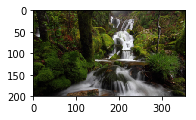

In [25]:
input = image_loader("/home/chintan/Class_Code/Class19(Deep Dream)/Prisma Resources/images/Lock (42).jpg").type(dtype)
# if we want to fill it with a white noise:
# input.data = torch.randn(input.data.size()).type(dtype)

# add the original input image to the figure:
plt.subplot(223)
imshow(input.data)
plt.show()

In [26]:
# this line to show that input is a parameter that requires a gradient
input = nn.Parameter(input.data)       #isi ko optimize krna h (parameter obkject is differentiabe)
optimizer = optim.LBFGS([input])       #like adam optimizer

run [10]:


/home/chintan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(49.8546)
tensor(3.5158)


/home/chintan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


run [20]:
tensor(10.2726)
tensor(3.9824)
run [30]:
tensor(2.7634)
tensor(4.1459)
run [40]:
tensor(1.6327)
tensor(3.9570)
run [50]:
tensor(1.0544)
tensor(3.7782)
run [60]:
tensor(0.8489)
tensor(3.5844)
run [70]:
tensor(0.7184)
tensor(3.4437)
run [80]:
tensor(0.6415)
tensor(3.3247)
run [90]:
tensor(0.5922)
tensor(3.2003)
run [100]:
tensor(0.5519)
tensor(3.1274)
run [110]:
tensor(0.5275)
tensor(3.0568)
run [120]:
tensor(0.4956)
tensor(3.0161)
run [130]:
tensor(0.4763)
tensor(2.9694)
run [140]:
tensor(0.4503)
tensor(2.9392)
run [150]:
tensor(0.4353)
tensor(2.9091)
run [160]:
tensor(0.4145)
tensor(2.8882)
run [170]:
tensor(0.3989)
tensor(2.8666)
run [180]:
tensor(0.3825)
tensor(2.8510)
run [190]:
tensor(0.3699)
tensor(2.8355)
run [200]:
tensor(0.3547)
tensor(2.8243)
run [210]:
tensor(0.3392)
tensor(2.8121)
run [220]:
tensor(0.3251)
tensor(2.8003)
run [230]:
tensor(0.3116)
tensor(2.7917)
run [240]:
tensor(0.2976)
tensor(2.7841)
run [250]:
tensor(0.2871)
tensor(2.7759)
run [260]:
tensor(0.275

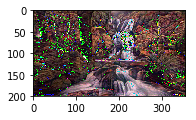

In [27]:
run = [0]
while run[0] <= 300:
    
    def closure():
        optimizer.zero_grad()
        model.forward(input)
        style_score = 0
        content_score = 0

        for sl in style_losses:           #for every style loss we backward pass
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()

        run[0]+=1
        if run[0] % 10 == 0:
            print("run " + str(run) + ":")
            print(style_score.data[0])
            print(content_score.data[0])

        return content_score+style_score

    optimizer.step(closure)            #Thsi closure is entire your one step

plt.subplot(224)
imshow(input.data)
plt.show()

If you try the code just above, you will obtain a beautiful white noise! Indeed, there is a last trick: the resulting optimized image takes its values between  −∞−∞ and  +∞+∞  instead of staying between 0 and 1. In other words, the image is well optimized, but has absurd values. In fact, we must perform an optimization under constraints in order to keep having right vaues into our input image. There is a simple solution: at each step, to correct the image to maintain its values into the 0-1 interval.

run [10]:
tensor(16574.3574, device='cuda:0')
tensor(18.2731, device='cuda:0')


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


run [20]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [30]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [40]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [50]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [60]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [70]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [80]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [90]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [100]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [110]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [120]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [130]:
tensor(10839.3936, device='cuda:0')
tensor(16.5094, device='cuda:0')
run [140]:
tensor(10839.3936, device='cuda:0')
t

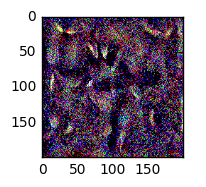

In [23]:
# run = [0]
# while run[0] <= 300:

#     def closure():
#         # correct the values of updated input image
#         input.data.clamp_(0, 1)

#         optimizer.zero_grad()
#         model.forward(input)
#         style_score = 0
#         content_score = 0

#         for sl in style_losses:
#             style_score += sl.backward()
#         for cl in content_losses:
#             content_score += cl.backward()

#         run[0]+=1
#         if run[0] % 10 == 0:
#             print("run " + str(run) + ":")
#             print(style_score.data[0])
#             print(content_score.data[0])

#         return content_score+style_score

#     optimizer.step(closure)

# # a last correction...
# input.data.clamp_(0, 1)
    
# # finally enjoy the result:
# plt.subplot(224)
# imshow(input.data)
# plt.show()

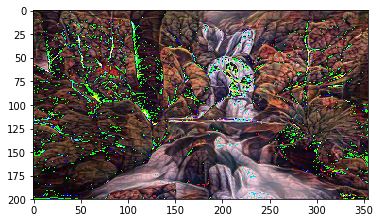

In [28]:
imshow(input.data)
plt.show()

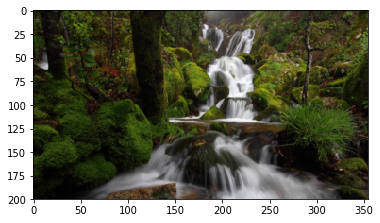

In [10]:
imshow(content.data)

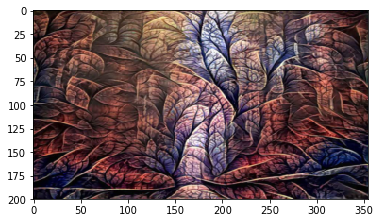

In [11]:
imshow(style.data)